In [1]:
import os

In [1]:
!pip install git+https://github.com/huggingface/transformers accelerate torch torchvision Pillow opencv-python faiss-cpu notebook datasets --target=/kaggle/working/workshop

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-wuko3klk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-wuko3klk
  Resolved https://github.com/huggingface/transformers to commit 7ee995fd9c692761c4601ddbffa2ac2ec9f27b0b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/13/9e/ee987874058f2d93006961f6ff49e0bcb60ab9c26709ebe06bfa8707a4d8/accelerate-0.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/6d/13/b5e8bacd980b2195f8a1741ce11cbb9146568607795d5e4ff510dcff1064/torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/84/eb/4f6483ae9094e164dc5b9b792e3

In [3]:
# Add /working/workshop to the path
import sys
sys.path.append("/kaggle/working/workshop")

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer
from torchvision.io import ImageReadMode, read_image
from transformers.models.bridgetower.modeling_bridgetower import BridgeTowerForContrastiveLearning
from transformers import Trainer, TrainingArguments
from transformers import AutoImageProcessor
import torch
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode, to_grayscale, to_tensor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Set up the data

In [5]:
# Load dataset
dset = load_dataset("jmhessel/newyorker_caption_contest", "matching")

Generating train split:   0%|          | 0/9792 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/531 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/528 [00:00<?, ? examples/s]

Dataset caption_contest downloaded and prepared to /root/.cache/huggingface/datasets/jmhessel___caption_contest/matching/1.0.0/43749f7b7c0566b3b1bb518ee81866c0ae27f310ad1b3405918479d6eafcaabe. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# Get the training dataset
train_dataset = dset["train"]

In [7]:
dset["train"]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
    num_rows: 9792
})

Some pirates are standing around a plank on a pirate ship. The man they were executing is diving into the water.


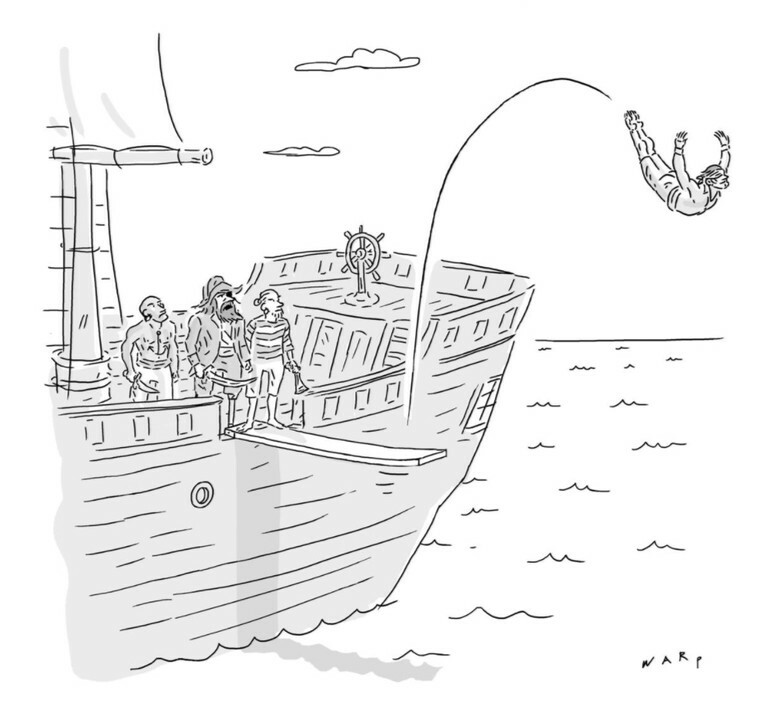

In [8]:
k = 213
print(dset["train"][k]['image_description'])
dset["train"][k]['image']

# Load pre-trained model and tokenizer

In [9]:
# Load pre-trained model and tokenizer
model_name_or_path = "BridgeTower/bridgetower-large-itm-mlm-itc"
model = BridgeTowerForContrastiveLearning.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenize the train dataset captions

In [11]:
# Tokenize captions using the tokenizer
def tokenize_captions(examples):
        captions = list(examples["image_description"])
        text_inputs = tokenizer(captions, max_length=128, padding="max_length", truncation=True)
        examples["input_ids"] = text_inputs.input_ids
        examples["attention_mask"] = text_inputs.attention_mask
        return examples

In [12]:
# Tokenize captions of all the train dataset
train_dataset = train_dataset.map(
            function=tokenize_captions,
            batched=True,
            remove_columns=[col for col in dset["train"].column_names if col != "image"],
            num_proc=None,
            desc="Running tokenizer on train dataset",
        )

Running tokenizer on train dataset:   0%|          | 0/10 [00:00<?, ?ba/s]

In [13]:
train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask'],
    num_rows: 9792
})

# Image preprocessing

In [14]:
# Convert image to grayscale and tensor
def get_image(image_or_path):
    image_or_path = to_grayscale(image_or_path, num_output_channels=3)
    return to_tensor(image_or_path)

In [15]:
# Preprocess of the image: Resize, CenterCrop, ConvertImageDtype and Normalize
class Transform(torch.nn.Module):
    def __init__(self, image_size, mean, std):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size], interpolation=InterpolationMode.BICUBIC),
            CenterCrop(image_size),
            ConvertImageDtype(torch.float),
            Normalize(mean, std),
        )

    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x

In [16]:
# Load image_processor, in this script we only use this to get the mean and std for normalization.
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)
image_size = model.config.vision_config.image_size

image_transformations = Transform(image_size, image_processor.image_mean, image_processor.image_std)

In [17]:
# Apply image transformations to the images in the examples
def transform_images(examples):
    images = [get_image(image_file) for image_file in examples["image"]]
    examples["pixel_values"] = [image_transformations(image) for image in images]
    return examples

In [18]:
# The transform (image processor) is applied on-the-fly on batches when __getitem__ is called
train_dataset.set_transform(transform_images)

# Training configuration

In [19]:
# The function to use to form a batch from a list of elements of train_dataset
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

In [20]:
# Define training arguments

num_train_epochs = 1
per_device_train_batch_size = 8
use_lazy_mode = True
learning_rate = 5e-05

training_args = TrainingArguments(
    output_dir="test_trainer",
    remove_unused_columns=False,
    num_train_epochs=1,
    per_device_train_batch_size=per_device_train_batch_size,
    learning_rate=learning_rate,
    report_to=[],
    logging_steps=50
)

# training_args = GaudiTrainingArguments(
#     output_dir="test_trainer",
#     remove_unused_columns=False,
#     use_habana=True,
#     use_lazy_mode=use_lazy_mode,
#     use_hpu_graphs_for_inference=True,
#     gaudi_config_name="Habana/clip",
#     num_train_epochs=num_train_epochs,
#     per_device_train_batch_size=per_device_train_batch_size,
#     learning_rate=learning_rate,
#     report_to=[],
#     logging_steps=50,
#     dataloader_num_workers = 1
# )

In [22]:
training_args

TrainingArguments(
_n_gpu=2,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_length=False,
half_precision_backend=au

In [24]:
# Initalize the trainer

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        data_collator=collate_fn,
    )

# Train the model 😃

In [29]:
# Train the model
train_result = trainer.train(resume_from_checkpoint=None)

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bridgetower/modeling_bridgetower.py", line 1835, in forward
    outputs = self.bridgetower(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bridgetower/modeling_bridgetower.py", line 1450, in forward
    layer_outputs_image = self.cross_modal_image_layers[link_layer_index + 1](
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bridgetower/modeling_bridgetower.py", line 641, in forward
    self_attention_outputs = self.attention(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bridgetower/modeling_bridgetower.py", line 604, in forward
    self_outputs = self.self(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/bridgetower/modeling_bridgetower.py", line 515, in forward
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 14.76 GiB total capacity; 13.48 GiB already allocated; 3.75 MiB free; 13.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


# Test the model

Two priests and a rabbi are walking into a bar, as the bartender and another patron look on. The bartender talks on the phone while looking skeptically at the incoming crew.


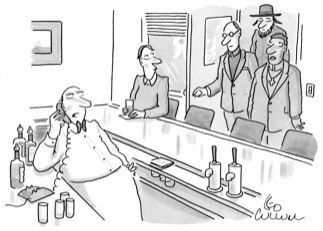

In [26]:
INDX_EXAMPLE_1 = 0
print(dset["train"][INDX_EXAMPLE_1]['image_description'])
dset["train"][INDX_EXAMPLE_1]['image']

Two giraffes are in a house. One is on the couch watching TV.


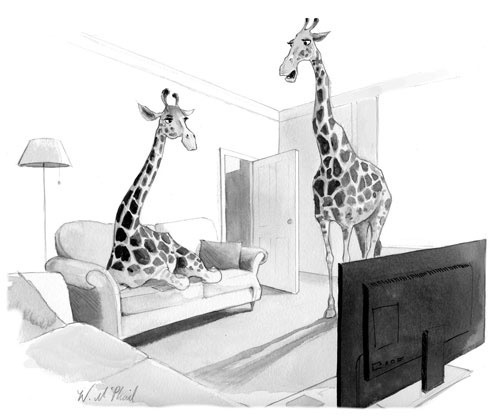

In [27]:
INDX_EXAMPLE_2 = 5
print(dset["train"][INDX_EXAMPLE_2]['image_description'])
dset["train"][INDX_EXAMPLE_2]['image']

In [28]:
# Set the device to cuda
device = torch.device("cuda")

ex_1 = train_dataset[INDX_EXAMPLE_1]  # Get example 1 from the train dataset
ex_2 = train_dataset[INDX_EXAMPLE_2]  # Get example 2 from the train dataset


# Extract pixel values, input IDs, and attention mask from example 1
pixel_values_1 = torch.stack([ex_1['pixel_values']]).to(device)
input_ids_1 = torch.tensor([ex_1['input_ids']]).to(device)
attention_mask_1 = torch.tensor([ex_1['attention_mask']]).to(device)


# Extract pixel values, input IDs, and attention mask from example 2
pixel_values_2 = torch.stack([ex_2['pixel_values']]).to(device)
input_ids_2 = torch.tensor([ex_2['input_ids']]).to(device)
attention_mask_2 = torch.tensor([ex_2['attention_mask']]).to(device)



# Create an encoding dictionary for example 1
encoding_1 = {
    "pixel_values": pixel_values_1,
    "input_ids": input_ids_1,
    "attention_mask": attention_mask_1,
}

# Pass the example to the fine-tuned model
outputs_1 = trainer.model(**encoding_1)
logits_text_to_image_1 = torch.matmul(outputs_1['text_embeds'], outputs_1['image_embeds'].t()).to('cpu')
print(f"logits_text_to_image_1: {logits_text_to_image_1}")

logits_text_to_image_1: tensor([[0.2813]], grad_fn=<ToCopyBackward0>)


In [ ]:
torch.cuda.empty_cache()